# Text preprocessing

- Cleaning
    - Non-text
        - Punctuation
        - JavaScript
    - Encoding

- Segmentation

    - Sentence segmentation (sentence boundary recognition): Document -> Sentence

    - Tokenization
        - Character level
        - Subword level: Byte Pair Encoding or WordPiece
        - Word level

- Normalization

    - Spell checking and correction

    - Lowercase
    
    - Standardization

- Stopword removal

- Morphological processing

    - Stemming (词干提取): Remove derivation morphology: happiness -> happy
    
    - Lemmatization (词形还原): Remove inflection morphology: better -> good

- build vocabulary from training set. 

    - all novel words at test set are replaced by [UNK] token.

- Part-of-speech tagging

- Entity recognition
    - Special characters (emoticons and emojis)
    - Named entity
    - URLs, emails
    - Numbers and dates


### sentence segmentation

Sentence boundary recognition, also known as sentence segmentation, is the task of identifying the boundaries between sentences in a given text. 

It is an essential preprocessing step in many NLP tasks, such as parsing, machine translation, and information extraction. 

Sentence boundary recognition can be treated as a classification problem, where each potential boundary (usually a punctuation mark) is classified as either a sentence boundary or not.

To perform sentence boundary recognition, various features can be used, including:

- Punctuation: Periods `.`, question marks `?`, and exclamation marks `!`.

- Formatting: Line breaks, paragraph breaks.

- Fonts: Changes in font style or size.

- Spacing: spaces before and after punctuation marks. For example, if there is no space after a period, it is less likely to be a sentence boundary.

- Capitalization: The first word of a sentence is typically capitalized in many languages.

- Case: Similar to capitalization, the case of characters in a word can provide clues about sentence boundaries.

- Use of abbreviations: Certain abbreviations, like "Dr." or "a.m.", may be followed by a period but not necessarily indicate the end of a sentence.

 

# subword tokenization

## algorithm

| subword tokenization algorithm                | BPE                        | WordPiece                      |
|------------------------|----------------------------|--------------------------------|
| Vocab Initialization         | all raw characters   | all raw characters and some common subwords      |
| Token selection        | Most frequent byte pairs | maximum likelihood of a token given its surrounding context.  |
| Tokenization process   | Greedy longest match      | Greedy based on likelihood     |
| Pros                   | Simple, language-agnostic | Better token selection in context |
| Cons                   | Suboptimal token selection | language-dependent, Requires predefined vocabulary |


## motivation

- unit of vocabulary in subword tokenization is subword (parts of words, bytes, characters)

    byte: not refer to traditional definition of a storage unit -  byte = 8 bit. it means a string of characters the BPE algorithm operate on.

- finite vocabulary assumption:  a fixed vocab of tens of thousands of words, built from the training set,  all novel words in test set are replaced as [UNK] token.

- issue of finite vocab assumption: 

    - many languages has complex morphology, representing Tense, mood, definiteness, negation, information about the object, etc.
    
    - simply replace novel words of different morphology in test set as unknown tokens and have same embeddings will loss many information.

    - morphology processing (stemming and lemmatization) can only address part of issue:
    
        - loss of information: words at base or root form result in ambiguity without context. morphological features carry important syntactic or semantic information are lost.

        - languge-dependent: Stemming and lemmatization algorithms are typically language-dependent, requiring separate rule sets or resources for each language. This makes them less flexible and scalable than subword encoding techniques like BPE, which can be applied across languages.



# Tutorial

## library

In [ ]:
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer 
import itertools
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt') # download the punctuation file
nltk.download('wordnet') # download Wordnet
nltk.download('averaged_perceptron_tagger') # download POS tagger
nltk.download('tagsets') # download the UPENN dataset
nltk.download('maxent_ne_chunker') # download # named entity chunker
nltk.download('words')

## Load text File


Medical Information Mart for Intensive Care III (MIMIC-III) 

is a large, freely-available database comprising deidentified health-related data associated with over 40,000 patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

MIMIC-III is important dataset becuase:

*   is freely available to researchers worldwide
*   encompasses a diverse and very large population of ICU patients
*   contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

The microbiology events file

This file is comprised of around 2003 patients with 18 variables. 

Those variables describe the antibiotics that these patients took as a treatment for infections including medication id, name, dilution, and interaction with other drugs, the list of conditions they had. 

In [ ]:
# Load the MICROBIOLOGYEVENTS MIMIC-III file 
data = pd.read_csv("/Users/wenxinxu/Desktop/CBB-750/data/MICROBIOLOGYEVENTS.csv")

# first check the size of the file
print (data.shape)

# Familiarize yourself with the features/variables
print (data.columns)

# last column has NaN values. drop ALL rows that have at least one column with NaN value.
Edata = data.dropna()
print ("Size of data after dropping null columns is: ",Edata.shape)

# reset index of rows. The rows from 8-37 were dropped becasue they had Nan Values. 
Edata.reset_index(inplace=True)
# Print the first 10 rows in the data
Edata.head(10)

(2003, 18)
Index(['row_id', 'subject_id', 'hadm_id', 'chartdate', 'charttime',
       'spec_itemid', 'spec_type_desc', 'org_itemid', 'org_name',
       'isolate_num', 'ab_itemid', 'ab_name', 'dilution_text',
       'dilution_comparison', 'dilution_value', 'interpretation',
       'ab_interactions', 'ab_class'],
      dtype='object')
Size of data after dropping null columns is:  (915, 18)


,index,row_id,subject_id,hadm_id,chartdate,charttime,spec_itemid,spec_type_desc,org_itemid,org_name,isolate_num,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,ab_interactions,ab_class
0,1,134695,10006,142345,2164-10-23 00:00:00,2164-10-23 15:30:00,70012,BLOOD CULTURE,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",1.0,90015.0,VANCOMYCIN,2,=,2.0,S,Leuprolide may decrease the excretion rate of ...,"Diarrhea|Meningitis, Pneumococcal|Vancomycin|E..."
1,2,134696,10006,142345,2164-10-23 00:00:00,2164-10-23 15:30:00,70012,BLOOD CULTURE,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",1.0,90012.0,GENTAMICIN,<=0.5,<=,1.0,S,Gentamicin may decrease the excretion rate of ...,Central Nervous System Infections|Decreased Pr...
2,3,134697,10006,142345,2164-10-23 00:00:00,2164-10-23 15:30:00,70012,BLOOD CULTURE,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",1.0,90025.0,LEVOFLOXACIN,4,=,4.0,I,The risk or severity of QTc prolongation can b...,Decreased DNA Integrity|Salmonella Infections|...
3,4,134698,10006,142345,2164-10-23 00:00:00,2164-10-23 15:30:00,70012,BLOOD CULTURE,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",1.0,90016.0,OXACILLIN,=>4,=>,4.0,R,Leuprolide may decrease the excretion rate of ...,Gram-Positive Bacterial Infections|Enzyme Acti...
4,5,134699,10006,142345,2164-10-23 00:00:00,2164-10-23 15:30:00,70012,BLOOD CULTURE,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",1.0,90011.0,TETRACYCLINE,<=1,<=,1.0,S,Leuprolide may decrease the excretion rate of ...,Granuloma Inguinale|Cell Membrane Alteration|S...
5,6,134700,10006,142345,2164-10-23 00:00:00,2164-10-23 15:30:00,70012,BLOOD CULTURE,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",1.0,90006.0,ERYTHROMYCIN,=>8,=>,8.0,R,The risk or severity of bleeding can be increa...,Syphilis|Pimozide|Erythrasma|Gastroenteritis|S...
6,7,134701,10006,142345,2164-10-23 00:00:00,2164-10-23 15:30:00,70012,BLOOD CULTURE,80155.0,"STAPHYLOCOCCUS, COAGULASE NEGATIVE",1.0,90002.0,PENICILLIN,=>0.5,=>,1.0,R,The serum concentration of Moxifloxacin can be...,Bacterial Infections|Salmonella Infections|Ant...
7,38,134802,10019,177759,2163-05-14 00:00:00,2163-05-14 21:52:00,70012,BLOOD CULTURE,80055.0,GRAM POSITIVE COCCUS(COCCI),1.0,90006.0,ERYTHROMYCIN,=>8,=>,8.0,R,The risk or severity of bleeding can be increa...,Syphilis|Pimozide|Erythrasma|Gastroenteritis|S...
8,39,134803,10019,177759,2163-05-14 00:00:00,2163-05-14 21:52:00,70012,BLOOD CULTURE,80055.0,GRAM POSITIVE COCCUS(COCCI),1.0,90002.0,PENICILLIN,<=0.06,<=,0.0,S,The serum concentration of Moxifloxacin can be...,Bacterial Infections|Salmonella Infections|Ant...
9,40,134804,10019,177759,2163-05-14 00:00:00,2163-05-14 21:52:00,70012,BLOOD CULTURE,80172.0,ENTEROCOCCUS FAECALIS,1.0,90025.0,LEVOFLOXACIN,1,=,1.0,S,The risk or severity of QTc prolongation can b...,Decreased DNA Integrity|Salmonella Infections|...


## Extract text

In [ ]:
#print(Edata.loc[Edata['sepsis']==True])
text = Edata['ab_interactions']

print (text[20]) # print 'ab_interactions' column of 20th doc

# Exactly how many documents are there?
len(text) # the same as number of rows

The risk or severity of QTc prolongation can be increased when Leuprolide is combined with Ciprofloxacin. The risk or severity of QTc prolongation can be increased when Goserelin is combined with Ciprofloxacin. Salmon Calcitonin may decrease the excretion rate of Ciprofloxacin which could result in a higher serum level. The serum concentration of Ciprofloxacin can be increased when it is combined with Gramicidin D. The therapeutic efficacy of Insulin human can be increased when used in combination with Ciprofloxacin. The therapeutic efficacy of Insulin human can be increased when used in combination with Ciprofloxacin. Desmopressin may decrease the excretion rate of Ciprofloxacin which could result in a higher serum level. Aldesleukin may decrease the excretion rate of Ciprofloxacin which could result in a higher serum level. The therapeutic efficacy of Insulin lispro can be increased when used in combination with Ciprofloxacin. The therapeutic efficacy of Insulin lispro can be increas

915

## Transforming Raw Text into Features

Transform raw text into *linguistic units*. 

For example, a sentence is "a grammatical unit of one or more words that expresses an independent statement, question, request, command, exclamation, etc., and that typically has a subject 主语 as well as a predicate 谓语, as in 'Bob is here'. or 'Is Bob here?'"

We want to find the content within a text by (1) identifying the sentences, (2) getting the content from each sentence, (3) ultimately aggregate the content from each sentence to achieve full understanding of the whole text.

**Steps**.

1.   Sentence segmentation 
2.   Tokenization 
3.   Normalization
        * Lowercase
        * Stemming: remove affix 
        * Lemmatization remove infectional morphology
4.   Stop words removal 
5.   Regular expression
6.   Part-of-speech tagging 
7.   Named Entity Recognition


### 1. sentence segmentation



In [ ]:
# extract first document from the list of documents 'text' 
doc = text[1]
# split the document into a list of sentences
sents = nltk.sent_tokenize(doc)
print ('There are {} sentences in this document '.format(len(sents)))
print(type(sents))

# Print sentences each on a line 
for i, s in enumerate(sents):
    print ("sentence %d: " % i, s)
    break 

There are 823 sentences in this document 
<class 'list'>
sentence 0:  Gentamicin may decrease the excretion rate of Leuprolide which could result in a higher serum level.


### 2.  Tokenization

In [ ]:
# use 10-th sentence in the document
sent = sents[10]

# Extract **tokens** of words in a sentence using a tokenizer
tokens = nltk.word_tokenize(sent) # return a list of tokens, include 句号 period

tokens

['The',
 'risk',
 'or',
 'severity',
 'of',
 'adverse',
 'effects',
 'can',
 'be',
 'increased',
 'when',
 'Gentamicin',
 'is',
 'combined',
 'with',
 'Botulinum',
 'toxin',
 'type',
 'A',
 '.']

### 3. Normalization

In [ ]:
# lowercase by lower()
normalized_tokens = [t.lower() for t in tokens]
print ('\nnormaized tokens AFTER lowercase ')
print( normalized_tokens)

# stemming by nltk.PorterStemmer().stem()
print ('\nnormaized tokens AFTER stemming ')
print ([nltk.PorterStemmer().stem(t) for t in normalized_tokens])

# lemmatization
print ('\nnormaized tokens AFTER lemmatization')
print ([WordNetLemmatizer().lemmatize(t,pos='v') for t in normalized_tokens])


normaized tokens AFTER lowercase 
['the', 'risk', 'or', 'severity', 'of', 'adverse', 'effects', 'can', 'be', 'increased', 'when', 'gentamicin', 'is', 'combined', 'with', 'botulinum', 'toxin', 'type', 'a', '.']

normaized tokens AFTER stemming 
['the', 'risk', 'or', 'sever', 'of', 'advers', 'effect', 'can', 'be', 'increas', 'when', 'gentamicin', 'is', 'combin', 'with', 'botulinum', 'toxin', 'type', 'a', '.']

normaized tokens AFTER lemmatization
['the', 'risk', 'or', 'severity', 'of', 'adverse', 'effect', 'can', 'be', 'increase', 'when', 'gentamicin', 'be', 'combine', 'with', 'botulinum', 'toxin', 'type', 'a', '.']


## Descriptive stats

In [ ]:
# tokenize all the docs
tokens_of_Documents = [nltk.word_tokenize(doc) for doc in text]

# combine all the tokens in all documents into a list of tokens
tokens_all = list(itertools.chain.from_iterable(tokens_of_Documents))

print (len(tokens_all)) # totally 19668419 tokens in all documents

# lowercase and convert list of tokens to nltk text object
final_tokens = nltk.Text(t.lower() for t in tokens_all)

19668419


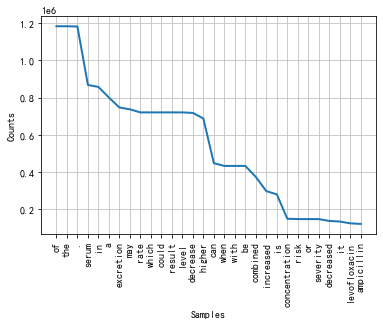

[('of', 1183859),
 ('the', 1183793),
 ('.', 1182580),
 ('serum', 867861),
 ('in', 857224),
 ('a', 800246),
 ('excretion', 746545),
 ('may', 736704),
 ('rate', 720140),
 ('which', 720140)]

In [ ]:
# frequency distribution of tokens
fdist = FreqDist(final_tokens)
#  x-axis is the words , y-axis is the frequcny
# show the top 30 words only
fdist.plot(30) 
#  most 10 frequent tokens: format (token, frequency)
fdist.most_common(10)

### 4. Stop words removal

Note that the most frequent words are common words in English that we call "stop words" 

e.g. may, could

becasue they are not important to the analysis and in fact distort the results.

let's remove them and see how they affect the order of the most frequent words distribution. 

In [ ]:
tokens_withno_stopwords = [w for w in final_tokens if w not in stop_words]           
print ("The number of tokens is %d ; AFTER stop words removel" % len(tokens_withno_stopwords))

The number of tokens is 12558717 ; AFTER stop words removel


### **Word Concordances** 词汇一致性

A word concordance captures the **context** around a word. 

the following example display the first 100 charcters of the first 5 matched lines that have the word "concentration". 

These paprameters can be changed as desired. 

In [ ]:
final_tokens.concordance('concentration',lines=5,width=100)

Displaying 5 of 147721 matches:
result in a higher serum level . the serum concentration of gentamicin can be increased when it is 
vities of tenofovir disoproxil . the serum concentration of gentamicin can be decreased when it is 
result in a higher serum level . the serum concentration of gentamicin can be decreased when it is 
 is combined with piperacillin . the serum concentration of gentamicin can be decreased when it is 
ne is combined with gentamicin . the serum concentration of digoxin can be increased when it is com


### 5. Regular Expressions

It allows us to search for patterns of strings in text using special arangements of special characters and numbers `(*$+a-z\0-9!={}^)`:


* `^` (Caret.) Matches the start of the string
* `|` or `"symbol"`
* `?` >=0 occurences of the preceding symbol, 
  - `behaviou?r` matches both behavior and behaviour
* `*` >=0 occurences of the preceding patterns
* `+` >=1 occurences of the preceding element 
* `\d` matches any single digit (same as `[0-9]` )* `\D` matches any single character that is not a digit (same as `[^0-9]` ).
* `/w` match any letter character, 
* `/W` match any character that is not letter
* `/s` match space
* `/S` match any characeter but not space
* `[  ]` match any characters in the brackets 
  - `[fc]at` matches fat, cat
* `{n}` match n copies of the target string
* `.` match periods 
* `()` match group of items in paranthesis, 
  - `(er)` matches player, 
  
  - `(t|r|e){2,3}` match any string that is `2` or `3` in size and has any of the letters `t`, `r`, or `e`.

use `re.compile(r"regular expression")` 

return matched character or string, rather than word

In [ ]:
# matches any single digit 0-9
p = re.compile(r'\d+')
p.findall('patient took 2 bills in the morning equivalent to 400mg and had 1 cup of water ')

['2', '400', '1']

In [ ]:
# match op
p1 = re.compile(r'op+')

# match o or op
p2 = re.compile(r'op*')

# match o or p
p3 = re.compile(r'o|p')

# match P
p4 = re.compile(r'^P')

# match o,n,i,s + t
p5 = re.compile(r'(o|n|i|s)t')

print ('p1', p1.findall('Patient took opioids in the past but not clear if he was prescribed opioids in this hospital, my opinion is not'))
print ('p2', p2.findall('Patient took opioids in the past but not clear if he was prescribed opioids in this hospital, my opinion is not'))
print ('p3', p3.findall('Patient took opioids in the past but not clear if he was prescribed opioids in this hospital, my opinion is not'))
print ('p4', p4.findall('Patient took opioids in the past but not clear if he was prescribed opioids in this hospital, my opinion is not'))
print ('p5', p5.findall('Patient took opioids in the past but not clear if he was prescribed opioids in this hospital, my opinion is not'))
print (p5.pattern)

p1 ['op', 'op', 'op']
p2 ['o', 'o', 'op', 'o', 'o', 'op', 'o', 'o', 'op', 'o', 'o']
p3 ['o', 'o', 'o', 'p', 'o', 'p', 'o', 'p', 'o', 'p', 'o', 'o', 'p', 'o', 'p', 'o', 'o']
p4 ['P']
p5 ['n', 's', 'o', 'i', 'o']
(o|n|i|s)t


### 6. POS Tagging


In [ ]:
sent = sents[10]
tokens = nltk.word_tokenize(sent)
pos_tokens = nltk.pos_tag(tokens)
pos_tokens

[('The', 'DT'),
 ('risk', 'NN'),
 ('or', 'CC'),
 ('severity', 'NN'),
 ('of', 'IN'),
 ('adverse', 'JJ'),
 ('effects', 'NNS'),
 ('can', 'MD'),
 ('be', 'VB'),
 ('increased', 'VBN'),
 ('when', 'WRB'),
 ('Gentamicin', 'NNP'),
 ('is', 'VBZ'),
 ('combined', 'VBN'),
 ('with', 'IN'),
 ('Botulinum', 'NNP'),
 ('toxin', 'NN'),
 ('type', 'NN'),
 ('A', 'NNP'),
 ('.', '.')]

**Meaning of tags**

you can download the UPENN dataset which explains these tags and run the command below to learn more about their definitions.

Examples of the tags are also displayed.

In [ ]:
# VBN: verb, past participle 过去分词
print (nltk.help.upenn_tagset('VBN'))

# NNP: noun, proper 专有名词, singular 单数
print (nltk.help.upenn_tagset('NNP'))

VBN: verb, past participle
    multihulled dilapidated aerosolized chaired languished panelized used
    experimented flourished imitated reunifed factored condensed sheared
    unsettled primed dubbed desired ...
None
NNP: noun, proper, singular
    Motown Venneboerger Czestochwa Ranzer Conchita Trumplane Christos
    Oceanside Escobar Kreisler Sawyer Cougar Yvette Ervin ODI Darryl CTCA
    Shannon A.K.C. Meltex Liverpool ...
None


### 7. Named Entity Recognition (NER)

classify named entities mentioned in text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, etc.

Note that the input to the "ne_chunk module is the list of **POS-tagged tokens** which we stored in the `pos_tokens` variable

In [ ]:
chunked_sentence = nltk.ne_chunk(pos_tokens)
print(chunked_sentence)


(S
  The/DT
  risk/NN
  or/CC
  severity/NN
  of/IN
  adverse/JJ
  effects/NNS
  can/MD
  be/VB
  increased/VBN
  when/WRB
  (PERSON Gentamicin/NNP)
  is/VBZ
  combined/VBN
  with/IN
  (PERSON Botulinum/NNP)
  toxin/NN
  type/NN
  A/NNP
  ./.)


Note how the ne-chunker assigned the category 'PERSON' to the medications (Gentamicin and Botulinum). 

`(PERSON Gentamicin/NNP)`

`(PERSON Botulinum/NNP)`

This is not the correct tag of course, which could happen!!

Here is another example ....

Looks better!
Gubler was tagged as person, CDC was tagged as organization

 `(PERSON Gubler/NNP)`
 
 ` (ORGANIZATION CDC/NNP)`

In [ ]:
tokens = nltk.word_tokenize(u"Dr. J. Gubler studied dengue at the CDC.")

pos_tokens = nltk.pos_tag(tokens)

chunked_sentence = nltk.ne_chunk(pos_tokens)

print (chunked_sentence)

(S
  Dr./NNP
  J./NNP
  (PERSON Gubler/NNP)
  studied/VBD
  dengue/NN
  at/IN
  the/DT
  (ORGANIZATION CDC/NNP)
  ./.)


## N-grams

are features  that have (n) words; where n={1,2,3,...}. 

* 1-gram has 1 word
* 2-gram has 2 words
* 3-gram has 3 words

In [ ]:
# a sentence with 20 tokens 20-4+1 = 17
print("sentence", sent)

# a list of 4-token tuples, totally 17 tuples
n_grams = ngrams(nltk.word_tokenize(sent), 4)

print(list(n_grams))
n_grams = ngrams(nltk.word_tokenize(sent), 4)
print('\nn-grams are:', [ ' '.join(grams) for grams in n_grams])

sentence The risk or severity of adverse effects can be increased when Gentamicin is combined with Botulinum toxin type A.
[('The', 'risk', 'or', 'severity'), ('risk', 'or', 'severity', 'of'), ('or', 'severity', 'of', 'adverse'), ('severity', 'of', 'adverse', 'effects'), ('of', 'adverse', 'effects', 'can'), ('adverse', 'effects', 'can', 'be'), ('effects', 'can', 'be', 'increased'), ('can', 'be', 'increased', 'when'), ('be', 'increased', 'when', 'Gentamicin'), ('increased', 'when', 'Gentamicin', 'is'), ('when', 'Gentamicin', 'is', 'combined'), ('Gentamicin', 'is', 'combined', 'with'), ('is', 'combined', 'with', 'Botulinum'), ('combined', 'with', 'Botulinum', 'toxin'), ('with', 'Botulinum', 'toxin', 'type'), ('Botulinum', 'toxin', 'type', 'A'), ('toxin', 'type', 'A', '.')]

n-grams are: ['The risk or severity', 'risk or severity of', 'or severity of adverse', 'severity of adverse effects', 'of adverse effects can', 'adverse effects can be', 'effects can be increased', 'can be increased w

## term-document matrix

- In this data, each patient is represented by a text document that describes interactions between their medications. 

- The text documents of the patients will be transformed into a matrix 

  - rows are the documents 
  
  - columns are the word features. 

  - cells: **frequency of words** in a document.  

## CountVectorizer

**CountVectorizer** is a module in sklearn that converts a collection of text documents into a matrix of tokens counts. 

The parameters are:

`max_features`: determines the number of features you want to use.

`ngram_range`: determines whether to generate unigram (`(1, 1)`), bigram (`(1, 2)`), trigram (`(1, 3)`) features,etc.

`stop_words`: if it is set to `english`, it will drop English stop words from the features set

In [ ]:
# `text` is a pd.series that conatins all the documents. 
text = Edata['ab_interactions']

text

0      Leuprolide may decrease the excretion rate of ...
1      Gentamicin may decrease the excretion rate of ...
2      The risk or severity of QTc prolongation can b...
3      Leuprolide may decrease the excretion rate of ...
4      Leuprolide may decrease the excretion rate of ...
                             ...                        
910    The metabolism of Trimethoprim can be increase...
911    The risk or severity of QTc prolongation can b...
912    The metabolism of Clindamycin can be increased...
913    The risk or severity of bleeding can be increa...
914    Leuprolide may decrease the excretion rate of ...
Name: ab_interactions, Length: 915, dtype: object

## define model and fit text data

In [ ]:
# define model 
tf_vectorizer = CountVectorizer(max_features=30,
                                ngram_range=(1, 2), 
                                stop_words='english' )

# apply the vectorizer to the docs
tf = tf_vectorizer.fit_transform(text)
# Learn the vocabulary dictionary and return term-document matrix.
# This is equivalent to fit followed by transform, but more efficiently implemented

**The vectorizer output** is a n_doc * 2 matrix

two columns:

the first column: tuple (doc index, token index) 

th second column: frequency of token in that document

In [ ]:
tf

<915x30 sparse matrix of type '<class 'numpy.int64'>'
	with 26024 stored elements in Compressed Sparse Row format>

In [ ]:
# print the features
tf_vectorizer.get_feature_names_out()

array(['ampicillin', 'ceftazidime', 'ciprofloxacin', 'combined',
       'concentration', 'decrease', 'decrease excretion', 'decreased',
       'decreased combined', 'efficacy', 'excretion', 'excretion rate',
       'higher', 'higher serum', 'increased', 'increased combined',
       'level', 'levofloxacin', 'meropenem', 'piperacillin', 'rate',
       'result', 'result higher', 'risk', 'risk severity', 'serum',
       'serum concentration', 'serum level', 'severity', 'trimethoprim'],
      dtype=object)

In [ ]:
print (tf)

  (0, 5)	673
  (0, 10)	713
  (0, 20)	713
  (0, 21)	713
  (0, 12)	673
  (0, 25)	713
  (0, 16)	713
  (0, 23)	59
  (0, 28)	59
  (0, 14)	75
  (0, 3)	59
  (0, 9)	62
  (0, 19)	2
  (0, 7)	6
  (0, 0)	2
  (0, 1)	2
  (0, 29)	1
  (0, 2)	1
  (0, 18)	2
  (0, 17)	2
  (0, 6)	673
  (0, 11)	713
  (0, 22)	673
  (0, 13)	673
  (0, 27)	713
  :	:
  (914, 20)	697
  (914, 21)	697
  (914, 12)	657
  (914, 25)	736
  (914, 16)	697
  (914, 14)	39
  (914, 3)	42
  (914, 9)	102
  (914, 19)	2
  (914, 7)	65
  (914, 0)	2
  (914, 1)	2
  (914, 29)	1
  (914, 2)	1
  (914, 18)	2
  (914, 17)	2
  (914, 6)	657
  (914, 11)	697
  (914, 22)	657
  (914, 13)	657
  (914, 27)	697
  (914, 4)	39
  (914, 8)	20
  (914, 26)	39
  (914, 15)	22


transform the sparse matrix into a dense matrix (pandas dataframe)

This form of the data is used in text mining and text classification

In [ ]:

pd.DataFrame(tf.todense(),columns=tf_vectorizer.get_feature_names_out())

,ampicillin,ceftazidime,ciprofloxacin,combined,concentration,decrease,decrease excretion,decreased,decreased combined,efficacy,...,rate,result,result higher,risk,risk severity,serum,serum concentration,serum level,severity,trimethoprim
0,2,2,1,59,0,673,673,6,0,62,...,713,713,673,59,59,713,0,713,59,1
1,2,2,1,269,42,511,511,72,49,41,...,511,511,511,211,211,553,42,511,211,1
2,4,4,2,1748,940,1312,972,488,480,364,...,1032,1032,972,502,502,1972,940,1032,502,2
3,2,2,1,42,39,657,657,65,20,102,...,697,697,657,0,0,736,39,697,0,1
4,2,2,1,622,502,691,543,261,219,166,...,575,575,543,36,36,1077,502,575,36,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,2,2,1,835,286,496,496,221,217,32,...,524,524,496,311,311,810,286,524,311,1411
911,4,4,2,1748,940,1312,972,488,480,364,...,1032,1032,972,502,502,1972,940,1032,502,2
912,0,0,1,519,12,4,0,258,255,23,...,0,0,0,73,73,12,12,0,73,0
913,0,0,1,904,350,21,21,198,190,10,...,23,23,21,324,324,373,350,23,324,1


- We can add trigrams to the new representation  by setting the upper bound of the `ngram_range` to `(1,3)`




In [ ]:
tf_vectorizer = CountVectorizer(max_features=20,
                                ngram_range=(1,3), 
                                stop_words='english' )

# apply the vectorizer to the "text" data
tf = tf_vectorizer.fit_transform(text)

#transform into dataframe
pd.DataFrame(tf.todense(),columns=tf_vectorizer.get_feature_names())

,combined,concentration,decrease,decrease excretion,decrease excretion rate,excretion,excretion rate,higher,higher serum,higher serum level,increased,level,rate,result,result higher,result higher serum,risk,serum,serum concentration,serum level
0,59,0,673,673,673,713,713,673,673,673,75,713,713,713,673,673,59,713,0,713
1,269,42,511,511,511,527,511,511,511,511,238,511,511,511,511,511,211,553,42,511
2,1748,940,1312,972,972,1100,1032,972,972,972,1394,1032,1032,1032,972,972,502,1972,940,1032
3,42,39,657,657,657,699,697,657,657,657,39,697,697,697,657,657,0,736,39,697
4,622,502,691,543,543,619,575,543,543,543,421,575,575,575,543,543,36,1077,502,575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,835,286,496,496,496,525,524,496,496,496,618,524,524,524,496,496,311,810,286,524
911,1748,940,1312,972,972,1100,1032,972,972,972,1394,1032,1032,1032,972,972,502,1972,940,1032
912,519,12,4,0,0,0,0,0,0,0,282,0,0,0,0,0,73,12,12,0
913,904,350,21,21,21,50,23,21,21,21,715,23,23,23,21,21,324,373,350,23


*decrease excertion* is a 2-word feature (2-gram) that appeared very frequently in the documents. 